In [1]:

import json, os, sys, math, requests, re, random, io
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import networkx as nx
from collections import Counter


In [2]:
# Load the JSON data
with open('data/processed/deputees_17.json', 'r', encoding='utf-8') as f:
    deputies = json.load(f)

with open('data/processed/vote_17.json', 'r', encoding='utf-8') as f:
    votes = json.load(f)

print(f"Loaded {len(deputies)} deputies")
print(f"Loaded {len(votes)} votes")

Loaded 611 deputies
Loaded 3404 votes


In [3]:
G = nx.Graph()

for deputy_id, deputy_info in deputies.items():
    G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))

print(f"Added {G.number_of_nodes()} nodes")

Added 611 nodes


In [4]:
# Track co-votes and total votes for each deputy pair
co_votes = {}  # Number of times both voted POUR together
deputy_votes = {}  # Track which votes each deputy participated in

# First pass: track which votes each deputy participated in
for vote_id, vote_data in votes.items():
    pour_voters = vote_data['votes_for']
    contre_voters = vote_data['votes_against']
    abstention_voters = vote_data['votes_abs']
    
    # All deputies who participated in this vote
    all_voters = set(pour_voters + contre_voters + abstention_voters)
    
    for deputy in all_voters:
        if deputy not in deputy_votes:
            deputy_votes[deputy] = set()
        deputy_votes[deputy].add(vote_id)
    
    # Track co-votes for POUR
    for i in range(len(pour_voters)):
        for j in range(i + 1, len(pour_voters)):
            deputy1 = pour_voters[i]
            deputy2 = pour_voters[j]
            
            if G.has_node(deputy1) and G.has_node(deputy2):
                pair = tuple(sorted([deputy1, deputy2]))
                co_votes[pair] = co_votes.get(pair, 0) + 0.5 



In [5]:
G = nx.Graph()

for deputy_id, deputy_info in deputies.items():
    G.add_node(deputy_id, name=deputy_info.get('name', 'Unknown'))
    
# Set threshold k (percentage between 0 and 1)
k = 0.30  # Deputies need to vote POUR together in at least k % of their common votes

# Second pass: create edges based on threshold
edges_added = 0
for (deputy1, deputy2), pour_count in co_votes.items():
    # Find common votes (votes both deputies participated in)
    common_votes = deputy_votes.get(deputy1, set()) & deputy_votes.get(deputy2, set())
    total_common = len(common_votes)
    
    if total_common > 0:
        percentage = pour_count / total_common
        G.add_edge(deputy1, deputy2, weight=percentage)
        

print(f"Graph created with {G.number_of_nodes()} nodes")


Graph created with 611 nodes


In [6]:
# Basic graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Check if graph is connected
if nx.is_connected(G):
    print("Graph is connected")
else:
    print(f"Graph has {nx.number_connected_components(G)} connected components")

Number of nodes: 611
Number of edges: 179915
Average degree: 588.92
Graph has 9 connected components


603 nodes in the giant connected component
[0.07194244604316546, 0.06935123042505593, 0.06626506024096386, 0.18421052631578946, 0.06231454005934718, 0.10330578512396695, 0.08875739644970414, 0.07390300230946882, 0.09351145038167939, 0.09210526315789473, 0.08241758241758242, 0.11946902654867257, 0.06313993174061433, 0.060546875, 0.07250755287009064, 0.07093821510297482, 0.07984790874524715, 0.06643356643356643, 0.06446540880503145, 0.09615384615384616]


C:\Users\tchir\AppData\Local\Temp\ipykernel_37844\435602150.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


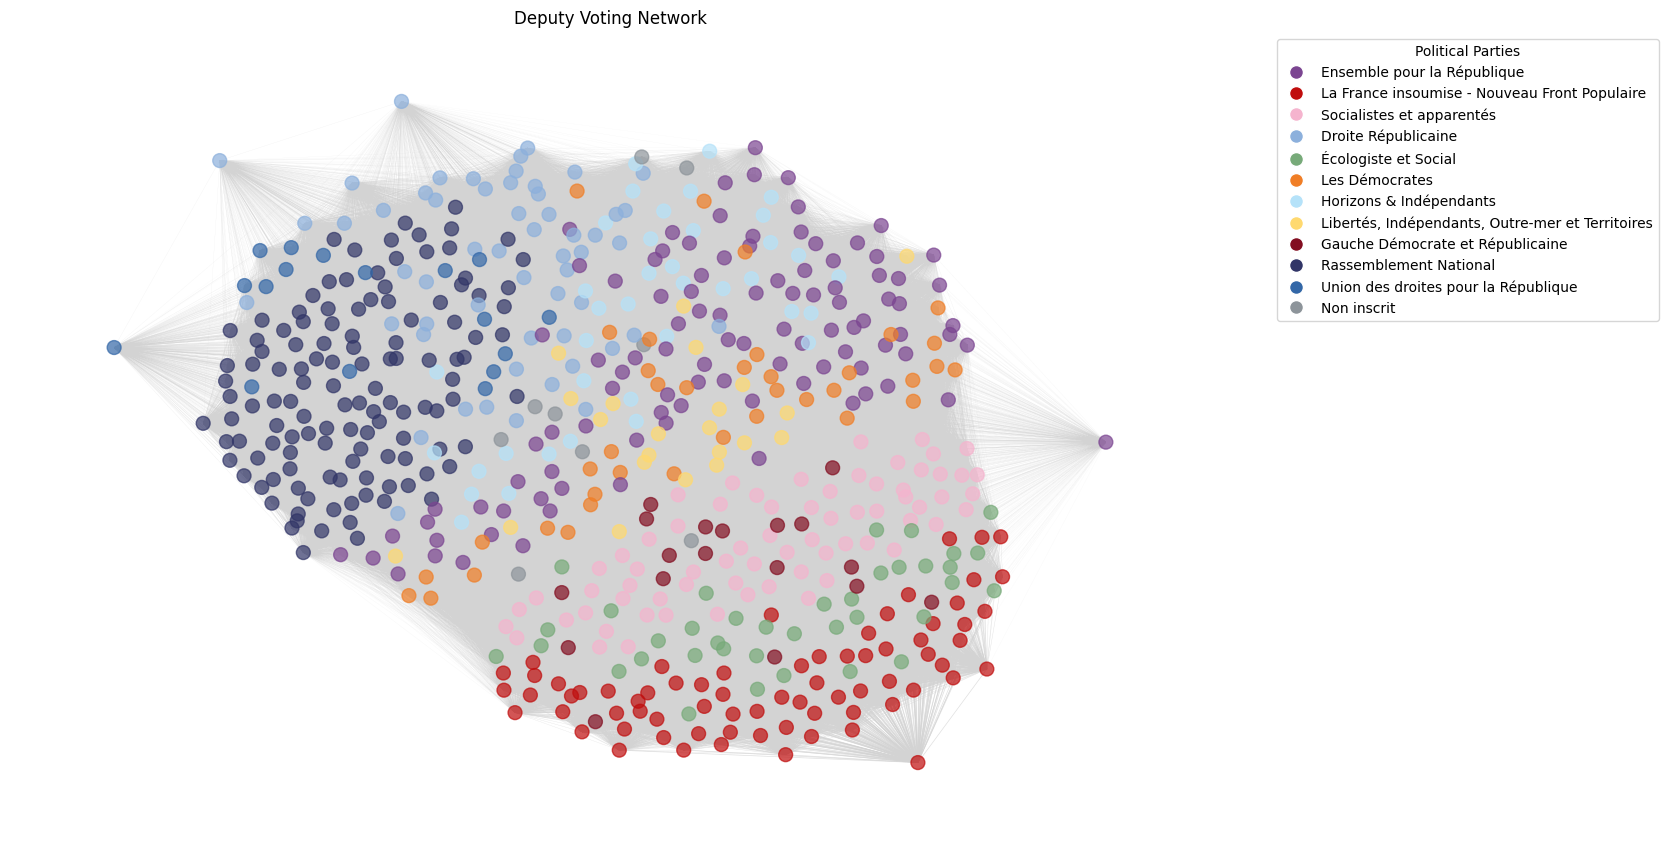

In [11]:

gcc_nodes = max(nx.connected_components(G), key=len)
GCC = G.subgraph(gcc_nodes).copy()

print(len(gcc_nodes), "nodes in the giant connected component")

nodes_color = [deputies[node].get('organ',{}).get('color','#cccccc') for node in GCC.nodes()]

party_colors = {deputies[node].get('organ',{}).get('color','#cccccc'):deputies[node].get('organ',{}).get('name','No name') for node in GCC.nodes()}



sample_nodes = list(GCC.nodes())
G_sample = GCC.subgraph(sample_nodes)

edge_weights = [G_sample[u][v]['weight'] for u, v in G_sample.edges()]
print(edge_weights[:20])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, weight='weight', seed=42)
nx.draw(G_sample, 
        pos, 
        node_size=100, node_color=nodes_color, 
        edge_color='lightgray',
        alpha=0.7, with_labels=False, width=edge_weights)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=name,
              markerfacecolor=color, markersize=10) for color, name in party_colors.items()],
           title="Political Parties", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Deputy Voting Network")
plt.tight_layout()
plt.show()

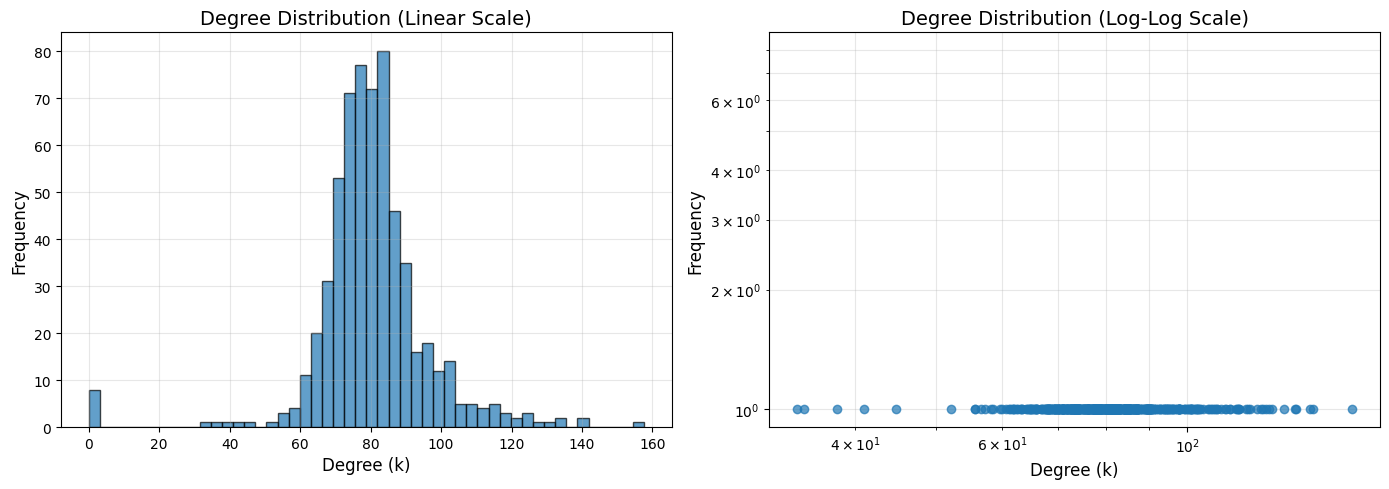

Mean degree: 80.46
Median degree: 79.91
Mode degree: 0
Min degree: 0
Max degree: 157.6247208381337
Standard deviation: 16.46


In [14]:
# Degree distribution
degrees = dict(G.degree(weight='weight'))
degree_values = list(degrees.values())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Linear scale
axes[0].hist(degree_values, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Degree (k)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Degree Distribution (Linear Scale)', fontsize=14)
axes[0].grid(alpha=0.3)

# Log-log scale for power-law detection
degree_counts = Counter(degree_values)
ks = sorted(degree_counts.keys())
counts = [degree_counts[k] for k in ks]

axes[1].loglog(ks, counts, 'o', markersize=6, alpha=0.7)
axes[1].set_xlabel('Degree (k)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Degree Distribution (Log-Log Scale)', fontsize=14)
axes[1].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Statistical summary
print(f"Mean degree: {np.mean(degree_values):.2f}")
print(f"Median degree: {np.median(degree_values):.2f}")
print(f"Mode degree: {max(set(degree_values), key=degree_values.count)}")
print(f"Min degree: {min(degree_values)}")
print(f"Max degree: {max(degree_values)}")
print(f"Standard deviation: {np.std(degree_values):.2f}")

In [15]:
# Calculate edge betweenness for backbone
edge_betweenness = nx.edge_betweenness_centrality(GCC)

# Normalize edge weights (1 to 100 scale)
values = list(edge_betweenness.values())
min_val, max_val = min(values), max(values)

# Create weighted graph
weighted_edges = [
    (u, v, 1 + 99 * (weight - min_val) / (max_val - min_val))
    for (u, v), weight in edge_betweenness.items()
]

G_weighted = GCC.copy()
G_weighted.clear_edges()
G_weighted.add_weighted_edges_from(weighted_edges)

# Extract backbone using disparity filter
df_edges = nx.to_pandas_edgelist(G_weighted, source='src', target='trg')
df_edges.rename(columns={'weight': 'nij'}, inplace=True)

# Apply disparity filter (using the function from your notebook)
df_filtered = disparity_filter(df_edges, undirected=True)

# Apply threshold
backbone_edges = thresholding(df_filtered, threshold=0.5)
print(f"Original network edges: {GCC.number_of_edges()}")
print(f"Backbone network edges: {len(backbone_edges)} ({100*len(backbone_edges)/GCC.number_of_edges():.1f}%)")

# Create backbone graph
G_backbone = nx.from_pandas_edgelist(backbone_edges, source='src', target='trg')
G_backbone = G_backbone.subgraph([n for n in G_backbone.nodes() if G_backbone.degree(n) > 0]).copy()

print(f"Backbone nodes: {G_backbone.number_of_nodes()}")
print(f"Backbone components: {nx.number_connected_components(G_backbone)}")

NameError: name 'disparity_filter' is not defined

## Communities

C:\Users\tchir\AppData\Local\Temp\ipykernel_37844\2913155220.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)
C:\Users\tchir\AppData\Local\Temp\ipykernel_37844\2913155220.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


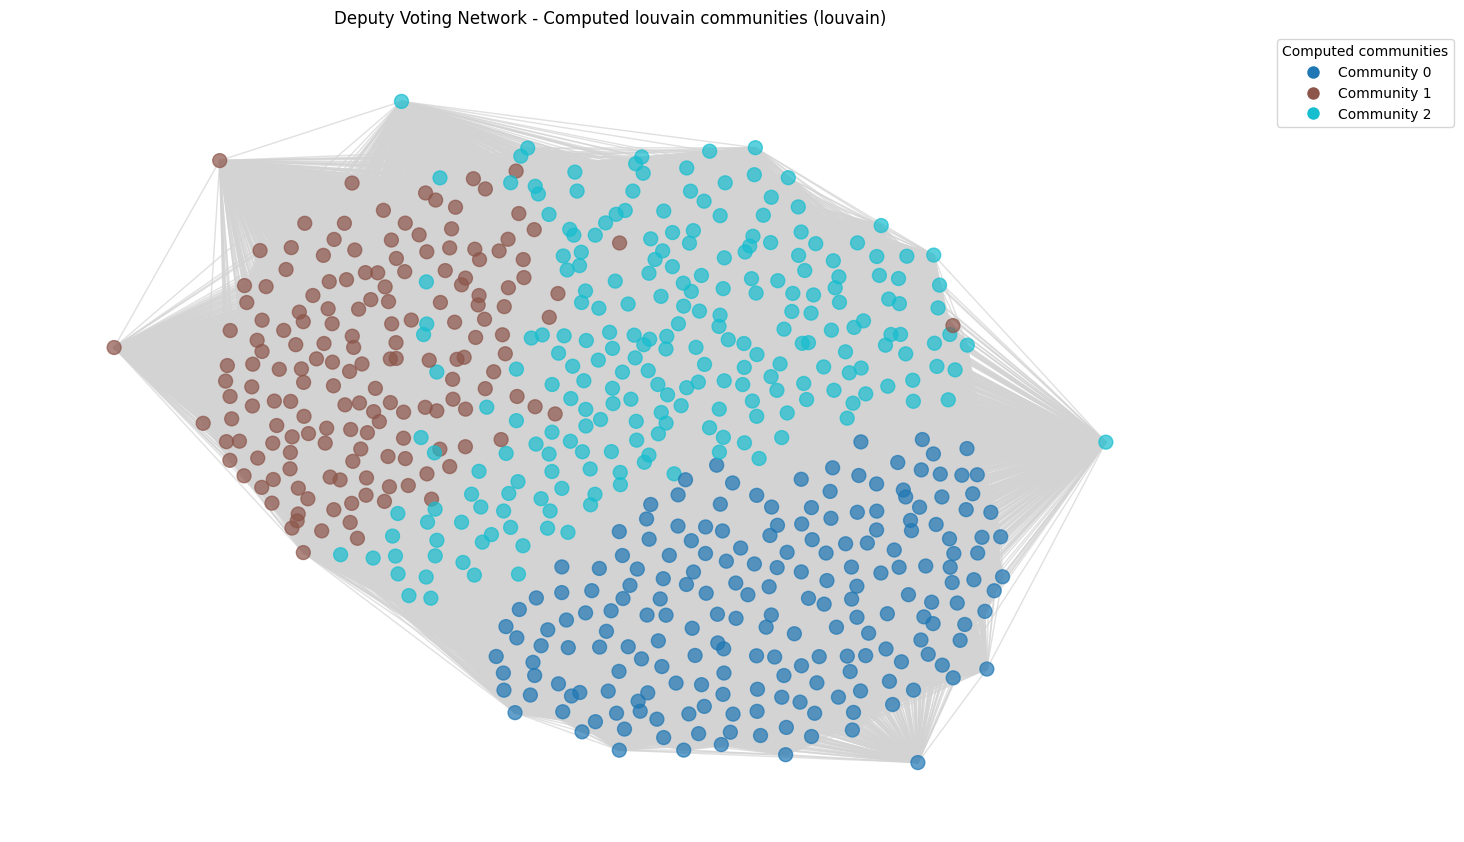

C0 : Regol Sandra , Écologiste et Social
C1 : Verny Gérault , Union des droites pour la République
C2 : Martin Sébastien , Droite Républicaine


In [17]:
communities_set = nx.community.louvain_communities(G_sample, weight="weight")
num_communities = len(communities_set)

partition = {}
for community_id, nodes in enumerate(communities_set):
    for node in nodes:
        partition[node] = community_id

cmap = plt.cm.get_cmap('tab10', num_communities) if num_communities <= 10 else plt.cm.get_cmap('viridis', num_communities)

# --- This is the list for node_color ---
nodes_color_com = [cmap(partition[node]) for node in G_sample.nodes()]

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Community {i}', markerfacecolor=cmap(i), markersize=10) for i in range(num_communities)]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, weight= 'weight', seed=42)
nx.draw(G_sample, 
        pos, 
        node_size=100, node_color=nodes_color_com, 
        edge_color='lightgray',
        alpha=0.7, with_labels=False)
plt.legend(handles=legend_handles,
           title="Computed communities", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Deputy Voting Network - Computed louvain communities (louvain)")
plt.tight_layout()
plt.show()

for i, community in enumerate(communities_set):
      r_idx = random.randint(0, len(list(community)))
      print(f"C{i} : {deputies[list(community)[r_idx]].get('name')} , {deputies[list(community)[r_idx]]['organ']['name']}")

In [18]:
organ_name_dict = {}
for dep in list(deputies.keys()):
    organ_id = deputies[dep]['organ']['id']
    organ_name = deputies[dep]['organ']['name']
    organ_short_name = deputies[dep]['organ']['name_short']
    if organ_id not in organ_name_dict:

        organ_name_dict[organ_id] = (organ_name, organ_short_name)

In [19]:
communities_dict = {}
for i,comm in enumerate(list(communities_set)):
    communities_dict[f"C{i}"] = comm

print(list(communities_dict.values()))

[{'PA1008', 'PA642764', 'PA840955', 'PA840829', 'PA842195', 'PA794146', 'PA794138', 'PA610654', 'PA721896', 'PA841367', 'PA795588', 'PA721062', 'PA774960', 'PA791824', 'PA841167', 'PA840997', 'PA842155', 'PA841023', 'PA841539', 'PA794710', 'PA722142', 'PA340343', 'PA795672', 'PA608264', 'PA841107', 'PA607553', 'PA841327', 'PA841717', 'PA605745', 'PA1567', 'PA795362', 'PA796062', 'PA841091', 'PA841893', 'PA793816', 'PA794938', 'PA331973', 'PA841665', 'PA795820', 'PA795876', 'PA841713', 'PA342196', 'PA333285', 'PA791812', 'PA796018', 'PA840171', 'PA794166', 'PA841853', 'PA721210', 'PA795998', 'PA794786', 'PA826635', 'PA793756', 'PA795808', 'PA774958', 'PA719930', 'PA795596', 'PA793464', 'PA841463', 'PA719578', 'PA794870', 'PA841215', 'PA606545', 'PA722150', 'PA841191', 'PA822617', 'PA720846', 'PA796090', 'PA335612', 'PA793780', 'PA720838', 'PA335999', 'PA795982', 'PA794778', 'PA793174', 'PA841919', 'PA794130', 'PA795240', 'PA793736', 'PA841729', 'PA841251', 'PA794478', 'PA794154', 'PA606

In [20]:
partis_members = {}
    
for id_member, data_member in deputies.items():
    # Récupère l'ID du parti
    id_parti = data_member['organ']['id']
    if id_parti in partis_members:
        partis_members[id_parti].append(id_member)
    else:
        partis_members[id_parti] = [id_member]

print(partis_members)

{'PO845407': ['PA795050', 'PA795958', 'PA795144', 'PA759832', 'PA718674', 'PA719372', 'PA795990', 'PA795884', 'PA721024', 'PA721908', 'PA722382', 'PA2960', 'PA720446', 'PA795950', 'PA335758', 'PA719798', 'PA795864', 'PA721158', 'PA719472', 'PA795386', 'PA720154', 'PA721916', 'PA794802', 'PA643184', 'PA642935', 'PA795664', 'PA720022', 'PA345722', 'PA719388', 'PA721852', 'PA722190', 'PA795920', 'PA720342', 'PA721750', 'PA721296', 'PA841709', 'PA795962', 'PA794798', 'PA267200', 'PA719338', 'PA842147', 'PA721134', 'PA817203', 'PA721426', 'PA720066', 'PA795528', 'PA719756', 'PA719632', 'PA721004', 'PA719890', 'PA842311', 'PA840235', 'PA722366', 'PA721764', 'PA719550', 'PA721584', 'PA607395', 'PA841927', 'PA720354', 'PA717379', 'PA795722', 'PA719404', 'PA793416', 'PA722102', 'PA720146', 'PA677483', 'PA793270', 'PA642695', 'PA606507', 'PA712014', 'PA720370', 'PA794330', 'PA719922', 'PA795908', 'PA794982', 'PA721170', 'PA841601', 'PA719412', 'PA795730', 'PA794206', 'PA722000', 'PA793940', 'PA7

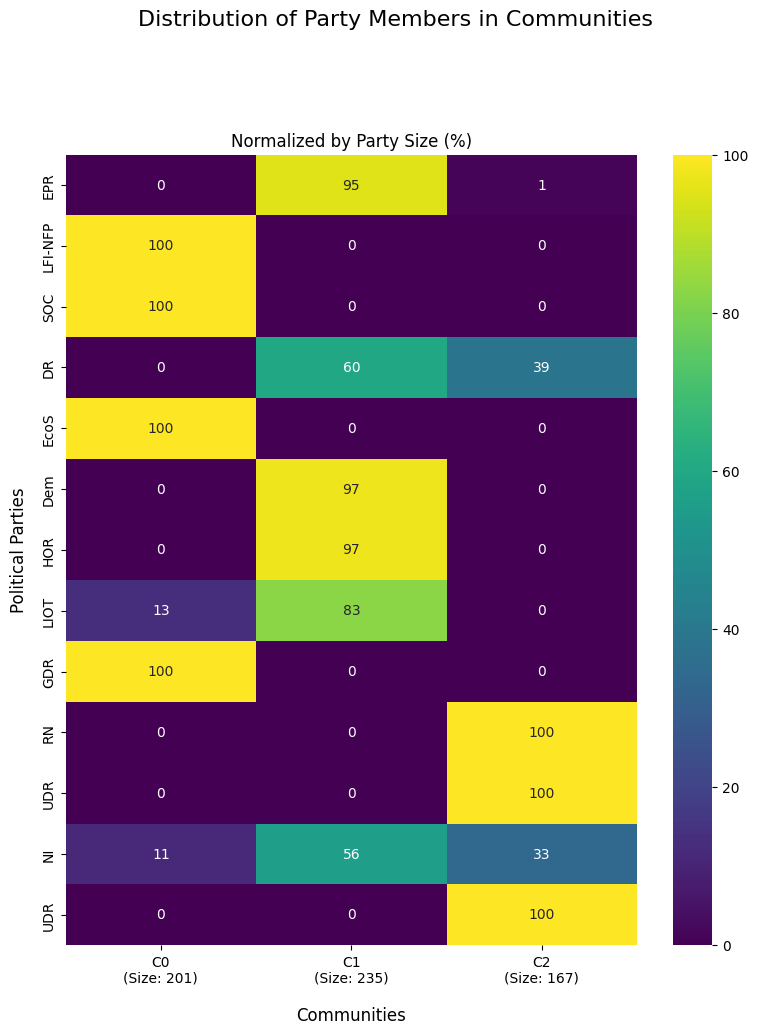

Community Key:
C0 : (Size: 201)
C1 : (Size: 235)
C2 : (Size: 167)


In [ ]:
def calculate_matrix_D(dict_partis, dict_commu_raw, all_member_ids, norm_vertical=False, norm_horizontal=True, plot=True):

    # Convert the raw frozenset dictionary into the (name, [members]) tuple format
    community_tuples = [] # This will be [(comm_key, [members]), ...]
    
    # Sort by key (C0, C1, ...) to ensure consistent order
    sorted_comm_keys = sorted(dict_commu_raw.keys()) 
    
    for comm_key in sorted_comm_keys:
        comm_set = dict_commu_raw[comm_key]
        members_in_comm = []
        
        # Only extract member IDs
        for item in comm_set:
            if item in all_member_ids:
                members_in_comm.append(item)
                
        # Store the KEY (C0, C1...) as the "name"
        community_tuples.append((comm_key, members_in_comm))
    
    
   
    party_member_lists = list(dict_partis.values())
    
    num_parti = len(party_member_lists)
    num_commu = len(community_tuples)
    
    D = np.empty(shape=(num_parti, num_commu))

    for i in range(0, num_parti):  # Iterate over parties (rows)
        party_i_members = party_member_lists[i]
        
        for j in range(0, num_commu): # Iterate over communities (columns)
            community_j_tuple = community_tuples[j]
            community_j_members = community_j_tuple[1] # Get the member list (index 1)
            
            # Find members from community j that are also in party i
            intersection = [d for d in community_j_members if d in party_i_members]
            D[i, j] = len(intersection)
            

            if norm_vertical:
                num_community_members = len(community_j_members)
                if num_community_members > 0: 
                    D[i, j] *= 100 / num_community_members
                else:
                    D[i, j] = 0 
            
            elif norm_horizontal:
                num_party_members = len(party_i_members)
                if num_party_members > 0: # Évite la division par zéro
                    D[i, j] *= 100 / num_party_members
                else:
                    D[i, j] = 0 # Parti vide
            

    if plot:
        # Axes X (Columns) and Y (Lines) : Communitie and genre names
        
        x_labels = [f"{community_tuple[0]}\n(Size: {len(community_tuple[1])})" for j, community_tuple in enumerate(community_tuples)]
        
        y_labels = [organ_name_dict[g][1] for g in list(dict_partis.keys())]
        
        fig_width = max(8, num_commu * 2.5) 
        fig_height = max(6, num_parti * 0.8)
        
        plt.figure(figsize=(fig_width, fig_height)) 
        
        sns.heatmap(
            D,
            annot=True,          # Show the numbers in each bloc
            fmt='.0f',           # Format as int
            cmap='viridis',      # Color (Blue=Weak, Yellow=Strong)
            xticklabels=x_labels,
            yticklabels=y_labels
        )
        plt.suptitle('Distribution of Party Members in Communities', fontsize=16, y=1.02)
        if norm_vertical:
            plt.title(f'Normalized by Community Size (%)')
        elif norm_horizontal:
            plt.title(f'Normalized by Party Size (%)')
        else:
            plt.title(f'Absolute Count of Members')
            
        plt.xlabel('Communities', fontsize=12, labelpad=15)
        plt.ylabel('Political Parties', fontsize=12, labelpad=10)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
        plt.show()
        
        print("Community Key:")
        for i, community_tuple in enumerate(community_tuples):
            print(f'{community_tuple[0]} : (Size: {len(community_tuple[1])})')
            
    return D

matrix_D = calculate_matrix_D(
    partis_members,       
    communities_dict, 
    plot=True,
    norm_vertical=False,
    norm_horizontal= True,
    all_member_ids = set(deputies.keys())
)